# Clustering

In [8]:
# Useful libraries
import pandas as pd
import pickle
import ast
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.sparse as sp
tqdm.pandas()

# Read the dataset

In [2]:
df=pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Number of unique products

In [4]:
df.ProductId.nunique()

74258

Number of total reviews

In [5]:
len(df)

568454

Throught a deep analysis on the products we noted that there are some duplicates ,for example the same User published the same rewiew at the same time for products which belong to the same family but having different flavour(chocolate,nut,vanilla...) or different size packaging(package of 8,16,32 pieces).We decide to mantain only one unique review for this family product.

In [6]:
sorted_data=df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

In [20]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...


Then we decide to merge all the reviews written by different Users but refered to the same product.This passage is necessary for the future clustering operations,otherwise the same product can belong to differet clusters.

In [10]:
final_series=final.groupby('ProductId').Text.apply(lambda x :','.join(x))

In [11]:
final_df=pd.DataFrame(final_series).reset_index()

In [12]:
final_df

,ProductId,Text
0,0006641040,In June<br />I saw a charming group<br />of ro...
1,141278509X,This product by Archer Farms is the best drink...
2,2734888454,My dogs loves this chicken but its a product f...
3,2841233731,This book is easy to read and the ingredients ...
4,7310172001,My dogs love these treats. The only problems I...
...,...,...
67552,B009RSR8HO,I've been using Fat to Skinny Zero since it wa...
67553,B009SF0TN6,You have to try this sauce to believe it! It s...
67554,B009SR4OQ2,I bought this Hazelnut Paste (Nocciola Spread)...
67555,B009WSNWC4,Purchased this product at a local store in NY ...


# Preprocessing 

At this point we have an organized dataset and we can preprocess all the reviews,for example removing stopwords,normalizing and keep only the stem of each word.

Then we decide to remove all the words with length of 2 or less ,because with a quickly visual analysis we discover that there are some writing mistakes made by the Users or some special review such : **'G-R-E-A-T-P-R-O-D-U-C-T'** and we don't want to consider this special cases.

In [14]:
tokenizer = RegexpTokenizer(r'[a-z]+') 
stop_words = set(stopwords.words("english"))
stemmer= SnowballStemmer("english") # PorterStemmer 
new_text = []
for text in tqdm(final_df['Text']):
    words=tokenizer.tokenize(text.lower())
    tokens_without_sw = [stemmer.stem(word) for word in words if word not in stop_words]
    for t in tokens_without_sw:
        if len(t)<=2:
            tokens_without_sw.remove(t)
    new_text.append(tokens_without_sw)
    

100%|███████████████████████████████████| 67557/67557 [08:45<00:00, 128.56it/s]


In [25]:
final_df['Reviews_Text'] = new_text

In [26]:
final_df.drop(columns=['Text'],inplace=True)

In [27]:
final_df.head()

,ProductId,Reviews_Text
0,0006641040,"[june, saw, charm, group, rose, begin, droop, ..."
1,141278509X,"[product, archer, farm, best, drink, mix, ever..."
2,2734888454,"[dog, love, chicken, product, china, wont, buy..."
3,2841233731,"[book, easi, read, ingredi, avail, store, unli..."
4,7310172001,"[dog, love, treat, problem, encount, left, pow..."


In [28]:
final_df.to_csv('Final_df.csv')

## Upload the preprocessed dataset

In [3]:
df=pd.read_csv('Final_df.csv',index_col=0)

In [4]:
df.head()

,ProductId,Reviews_Text
0,0006641040,"['june', 'saw', 'charm', 'group', 'rose', 'beg..."
1,141278509X,"['product', 'archer', 'farm', 'best', 'drink',..."
2,2734888454,"['dog', 'love', 'chicken', 'product', 'china',..."
3,2841233731,"['book', 'easi', 'read', 'ingredi', 'avail', '..."
4,7310172001,"['dog', 'love', 'treat', 'problem', 'encount',..."


In [7]:
#for reading the column Reviews_Text as list
df['Reviews_Text']=df.Reviews_Text.progress_apply(lambda s: list(ast.literal_eval(s)))

100%|███████████████████████████████████| 67557/67557 [01:14<00:00, 909.86it/s]


## Creating our TF_IDF
First we count the number of documents in which every word appears ,this is useful for the computation of tfidf score.

In [9]:
# word_id:number of documents in which it is
word_numberdoc = {}

for text in tqdm(df['Reviews_Text']):
    p = list(set(text))
    for word in p:
        if word in word_numberdoc:
            word_numberdoc[word]+=1
        else:
            word_numberdoc[word]=1  


100%|██████████████████████████████████| 67557/67557 [00:09<00:00, 7390.93it/s]


In [10]:
len(word_numberdoc)

78973

In [ ]:
with open('word_numberdoc.pkl', 'wb') as handle:
    pickle.dump(word_numberdoc, handle)

We decide to mantain all that words that are at least in 10 reviews and at most in 100000 reviews. This choice is made because the words which are in few reviews aren't meaningful or they have a writing mistake. Instead words that appeas in too many reviews caracterize almost all the product so they aren't so important for the clustering. The result is saved in separated dict.

In [16]:
word_numberdoc_useful = {}

for key, value in tqdm(word_numberdoc.items()):
    if value >= 10 and value <= 100000:
        word_numberdoc_useful[key] = value

100%|████████████████████████████████| 78973/78973 [00:00<00:00, 724480.37it/s]


In [17]:
len(word_numberdoc_useful)

14573

Excluding the words with low document frequency and with high frequency,we reduce the original number of words from approximately 78900 to 14573.


In [ ]:
with open('word_numberdoc_useful.pkl', 'wb') as handle:
    pickle.dump(word_numberdoc_useful, handle)

In [49]:
with open('word_numberdoc_useful.pkl', 'rb') as handle:
    word_numberdoc_useful = pickle.load(handle)

We map all the word with an integer and save them in a vocabulary

In [18]:
useful_vocabulary={}
for i,word in enumerate(word_numberdoc_useful):
    useful_vocabulary[word]=i    

In [ ]:
with open('useful_vocabulary.pkl', 'wb') as handle:
    pickle.dump(useful_vocabulary, handle)

In [6]:
with open('useful_vocabulary.pkl', 'rb') as handle:
    useful_vocabulary = pickle.load(handle)

Only for this words we calculate the tfidf

In [20]:
# create an inverted index with tfidf scoring
# - keys: index number of a word
# - values: {book in which the word appears, score of the word with respect to the book}
N_doc = len(df)
tfidf = defaultdict(list)

count = 0
for text in tqdm(df['Reviews_Text']):
    n=len(text)
    n_ij=dict(Counter(text))
    for word in n_ij:
        if word in word_numberdoc_useful.keys():
            tf=n_ij[word]/n
            Idf=np.log(N_doc/word_numberdoc_useful[word])
            tfidf[useful_vocabulary[word]].append((count,round(tf*Idf,5)))
        
    count += 1

100%|███████████████████████████████████| 67557/67557 [02:08<00:00, 524.36it/s]


In [ ]:
with open('tfidf_useful_word.pkl', 'wb') as handle:
    pickle.dump(tfidf, handle)

In [ ]:
with open('tfidf_useful_word.pkl', 'rb') as handle:
    a = pickle.load(handle)

Once we have the tfidf we create a sparse matrix with size [number of reviews,number of features],the non-zero values are the tf_idf scores for that review and the corrispondent words which contains. 

In [21]:
rows, cols, vals = [], [], []
for key, values in tqdm(tfidf.items()):
    for value in values:
        rows.append(value[0])
        cols.append(key)
        vals.append(value[1])

X = sp.csr_matrix((vals, (rows, cols)))

100%|██████████████████████████████████| 14573/14573 [00:12<00:00, 1143.36it/s]


In [ ]:
sparse.save_npz('matrice.npz',X)

In [ ]:
X=sparse.load_npz('matrice.npz')

Here we import the SVD model for dimensionality reduction of sklearn,and we calculate the variance explained by different number of features to be able to find the number which explains more than the 60% of the variance.

In [23]:
from sklearn.decomposition import TruncatedSVD

In [26]:
n_comp = [4,10,15,20,50,100,150,200,500,700,800] 
explained_ = [] 
for x in tqdm(n_comp):
    svd = TruncatedSVD(n_components=x)
    svd.fit(X)
    explained_.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

  9%|███▉                                       | 1/11 [00:02<00:25,  2.59s/it]

Number of components = 4 and explained variance = 0.023385617094432917


 18%|███████▊                                   | 2/11 [00:05<00:25,  2.78s/it]

Number of components = 10 and explained variance = 0.04500607212503198


 27%|███████████▋                               | 3/11 [00:09<00:25,  3.13s/it]

Number of components = 15 and explained variance = 0.057613480441508304


 36%|███████████████▋                           | 4/11 [00:14<00:25,  3.61s/it]

Number of components = 20 and explained variance = 0.06852667643123984


 45%|███████████████████▌                       | 5/11 [00:23<00:30,  5.16s/it]

Number of components = 50 and explained variance = 0.11703651141132171


 55%|███████████████████████▍                   | 6/11 [00:39<00:42,  8.42s/it]

Number of components = 100 and explained variance = 0.17219473986382458


 64%|███████████████████████████▎               | 7/11 [01:01<00:50, 12.61s/it]

Number of components = 150 and explained variance = 0.21427429162141387


 73%|███████████████████████████████▎           | 8/11 [01:31<00:53, 17.92s/it]

Number of components = 200 and explained variance = 0.24959195340012946


 82%|███████████████████████████████████▏       | 9/11 [04:45<02:20, 70.49s/it]

Number of components = 500 and explained variance = 0.3984632176121613


 91%|██████████████████████████████████████▏   | 10/11 [06:47<01:26, 86.06s/it]

Number of components = 700 and explained variance = 0.4688249605537563


100%|█████████████████████████████████████████| 11/11 [09:13<00:00, 104.01s/it]

Number of components = 800 and explained variance = 0.498891615334091


100%|██████████████████████████████████████████| 11/11 [09:13<00:00, 50.36s/it]


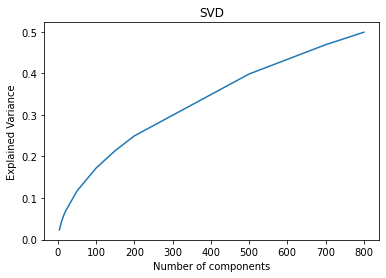

In [36]:
plt.plot(n_comp, explained_)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("SVD")
plt.show()

## Using Tfidf of sklearn
Import the built-in model of sklearn TFIDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

We have to pass in input the list of all the reviews so we create it from the dataset

In [27]:
corpus = []
for text in tqdm(df['Reviews_Text']):
    corpus.append(' '.join(text))

100%|███████████████████████████████████| 67557/67557 [04:34<00:00, 246.47it/s]


We fix the range of document frequecy as above:[10,100000] and repeat the same operations

In [30]:
vectorizer = TfidfVectorizer(min_df=10,max_df=100000,use_idf= True)
X_temp = vectorizer.fit_transform(corpus)

In [32]:
n_comp = [4,10,15,20,50,100,150,200,500,700,800] 
explained = []
for x in tqdm(n_comp):
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_temp)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

  9%|███▉                                       | 1/11 [00:02<00:28,  2.88s/it]

Number of components = 4 and explained variance = 0.05025905476733422


 18%|███████▊                                   | 2/11 [00:06<00:28,  3.11s/it]

Number of components = 10 and explained variance = 0.08452934320668629


 27%|███████████▋                               | 3/11 [00:10<00:27,  3.46s/it]

Number of components = 15 and explained variance = 0.10348777248014844


 36%|███████████████▋                           | 4/11 [00:15<00:27,  3.93s/it]

Number of components = 20 and explained variance = 0.11940362915397268


 45%|███████████████████▌                       | 5/11 [00:25<00:33,  5.66s/it]

Number of components = 50 and explained variance = 0.18680187147658403


 55%|███████████████████████▍                   | 6/11 [00:42<00:45,  9.17s/it]

Number of components = 100 and explained variance = 0.25749847347236615


 64%|███████████████████████████▎               | 7/11 [01:07<00:54, 13.68s/it]

Number of components = 150 and explained variance = 0.30837087222058773


 73%|███████████████████████████████▎           | 8/11 [01:40<00:58, 19.55s/it]

Number of components = 200 and explained variance = 0.3486179699038336


 82%|███████████████████████████████████▏       | 9/11 [05:03<02:29, 74.75s/it]

Number of components = 500 and explained variance = 0.5069566930440776


 91%|█████████████████████████████████████▎   | 10/11 [07:55<01:43, 103.68s/it]

Number of components = 700 and explained variance = 0.5743766567196257


100%|█████████████████████████████████████████| 11/11 [10:29<00:00, 118.77s/it]

Number of components = 800 and explained variance = 0.6019043277580844


100%|██████████████████████████████████████████| 11/11 [10:30<00:00, 57.31s/it]


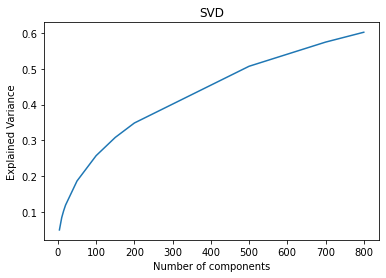

In [37]:
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("SVD")
plt.show()

# Comparing results

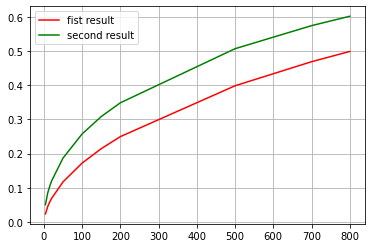

In [40]:
plt.plot(n_comp, explained_,color='r',label='fist result')
plt.plot(n_comp, explained,color='g',label='second result')
plt.grid()
plt.legend()
plt.show()

Here we can see that the results obtaind from the SVD Truncated method for the reduction of the number of features, is slightly different if we apply it on the sparse matrix of **tf_idf** coefficients generated from scratch by us , and if we apply it on the sparse matrix returnd by the built in model of sklearn TfidfVectorizer which created automatically a TF-IDF matrix given a collection of documents. The reason of this is that TfidfVectorizer use a reweighting of inverse frequency and a sort of Laplace Smoothing to avoid division by zero. Taking into account the second result instead of represent each review with 14000 features we can represent them with only 800 features obtained vy SVD reduction dimensionality. 

## Find the best 800 features

SVD dimension are linear combination of the original features.So for finding the 800 features that explain 60% od the data we:
1. Obtain all the features(words) from the vectorizer.

2. Use the svd_components which is a matrix of coefficient of each features are multiplied by.

3. To obtain the top 800 we sort the first dimension of svd_components and we find the relative features

In [47]:
features=vectorizer.get_feature_names()

In [49]:
best_features = [features[i] for i in svd.components_[0].argsort()[::-1]]

In [60]:
print(best_features[:800])

['tea', 'tast', 'like', 'coffe', 'flavor', 'product', 'good', 'love', 'great', 'use', 'one', 'tri', 'food', 'get', 'make', 'order', 'chocol', 'amazon', 'buy', 'would', 'dog', 'price', 'bag', 'time', 'eat', 'realli', 'find', 'drink', 'store', 'much', 'box', 'best', 'sugar', 'littl', 'also', 'mix', 'cup', 'sweet', 'well', 'even', 'better', 'packag', 'sauc', 'purchas', 'candi', 'treat', 'year', 'brand', 'look', 'day', 'recommend', 'cat', 'bought', 'pack', 'ship', 'free', 'snack', 'delici', 'water', 'found', 'want', 'bar', 'hot', 'high', 'first', 'give', 'enjoy', 'add', 'favorit', 'nice', 'made', 'way', 'think', 'cooki', 'fresh', 'local', 'need', 'could', 'work', 'know', 'say', 'differ', 'perfect', 'milk', 'bit', 'organ', 'sinc', 'bottl', 'thing', 'lot', 'two', 'got', 'qualiti', 'stuff', 'salt', 'green', 'bean', 'ingredi', 'still', 'mani', 'cook', 'wonder', 'ever', 'keep', 'come', 'hard', 'alway', 'never', 'review', 'chicken', 'oil', 'item', 'rice', 'soup', 'easi', 'everi', 'someth', 'size

In [62]:
with open('best_features.pkl', 'wb') as handle:
    pickle.dump(best_features[:800], handle)